In [1]:
from qutip import *
import numpy as np
from scipy import constants
import datetime
import time
import gc
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize_scalar
import math
from scipy.optimize import curve_fit
from scipy.sparse.linalg import eigs

In [2]:
c = 299792458
lam = 646e-9
lam=1e-9
f = c/lam
f

2.99792458e+17

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
#constants
hbar = constants.hbar
amu = constants.m_p
pi = constants.pi
MHz = 10**6;

In [5]:
#                       |e> 
#                    --------
#                    /     \
#  Δg, Ωg (probe!)  /       \  Δr, Ωr
#                  /         \ 
#                 /        -------
#             -------        |r> 
#               |g> 

In [6]:
#basis {e,r,g}
N = 3
e = basis(N,0)
r = basis(N,1)
g = basis(N,2)

In [7]:
def pope(Gamma, Deltar, Deltag, Omegar, Omegag):
    #Hamiltonian for a rest ion
    H1 =  Deltag*g*g.dag() + Deltar*r*r.dag()
    H2 = -0.5*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H = H1 + H2

    #c1 = sqrt(Gamma/3)*p*e.dag()
    c2 = np.sqrt(Gamma/2)*r*e.dag()
    c3 = np.sqrt(Gamma/2)*g*e.dag()

    #linbland operator/collapse operators
    c = [c2,c3]

    rho = steadystate(H,c)
    
    return expect(e*e.dag(),rho) #excited state population for rest ion

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [9]:
def steck(Gamma, Deltar, Deltag, Omegar, Omegag,Delta,eta): #fictitious lasers method

    #Rest Hamiltonian
    H1 = Deltag*g*g.dag() + Deltar*r*r.dag()
    H2 = -0.5*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H0 = H1 + H2

    c2 = np.sqrt(Gamma/2)*r*e.dag()
    c3 = np.sqrt(Gamma/2)*g*e.dag()

    c = [c2,c3]

    rho0 = steadystate(H0,c)

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))

    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    #Fuctitious lasers
    H1 = -0.5*(1j*eta*Omegag*g*e.dag() - 1j*eta*Omegar*r*e.dag())
    L1 = -1j*(spre(H1) - spost(H1))

    #L1 = np.array(L1)
    L1 = L1.data_as('ndarray')

    #Ht1 = 0.5*(1j*eta*Omegag*e*g.dag() -1j*eta*Omegar*e*r.dag())
    H_1 = H1.dag()
    L_1 = -1j*(spre(H_1) - spost(H_1))

    #L_1 = np.array(L_1)
    L_1 = L_1.data_as('ndarray')



    #matrix continued fractions method 
    #S3 = -np.matmul(inv(L0-3j*Delta*np.eye(N**2)),L1)
    #S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)+ np.matmul(L_1,S3)),L1)
    S2 = -np.matmul(inv(L0-2j*Delta*np.eye(N**2)),L1)
    S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2) + np.matmul(L_1,S2)),L1) 
    #S1 = -np.matmul(inv(L0-1j*Delta*np.eye(N**2)),L1) 

    #T_3 = -np.matmul(inv(L0+3j*Delta*np.eye(N**2)),L_1)
    #T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)+ np.matmul(L1,T_3)),L_1)
    T_2 = -np.matmul(inv(L0+2j*Delta*np.eye(N**2)),L_1)
    T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)+ np.matmul(L1,T_2)),L_1)
    #T_1 = -np.matmul(inv(L0+1j*Delta*np.eye(N**2)),L_1)
    
    L = np.matmul(L_1,S1) + L0 +np.matmul(L1,T_1)
    
    eigenvalues, eigenvectors = LA.eig(L)

    idx = find_nearest(eigenvalues, 0+0j)
    rhoss = eigenvectors[:,idx]

    #fixing column stacking
    rhos = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos[j,i] = rhoss[j+i*N]

    rho = Qobj(rhos)
    if rho.tr() != 0:
        rho = rho/rho.tr()

    rho_ = operator_to_vector(rho)
    #rho_ = np.array(rho_)
    rho_ = rho_.data_as('ndarray')

    rho1 = np.matmul(S1,rho_)
    #rho2 = np.matmul(S2,rho_)
    #rho3 = np.matmul(S3,rho_)

    rho_1 = np.matmul(T_1,rho_)
    #rho_2 = np.matmul(T_2,rho_)
    #rho_3 = np.matmul(T_3,rho_)

    rhos1 = np.zeros((N,N),dtype='complex64')
    #rhos2 = np.zeros((N,N),dtype='complex64')
    #rhos3 = np.zeros((N,N),dtype='complex64')
    rhos_1 = np.zeros((N,N),dtype='complex64')
    #rhos_2 = np.zeros((N,N),dtype='complex64')
    #rhos_3 = np.zeros((N,N),dtype='complex64')
    for i in range(N):
        for j in range(N):
            rhos1[j,i] = rho1[j+i*N]
            #rhos2[j,i] = rho2[j+i*N]
            #rhos3[j,i] = rho3[j+i*N]
            rhos_1[j,i] = rho_1[j+i*N]
            #rhos_2[j,i] = rho_2[j+i*N]
            #rhos_3[j,i] = rho_3[j+i*N]
            
    Rho1 = Qobj(rhos1)
    #Rho2 = Qobj(rhos2)
    #Rho3 = Qobj(rhos3)
    Rho_1 = Qobj(rhos_1)
    #Rho_2 = Qobj(rhos_2)
    #Rho_3 = Qobj(rhos_3)
       

    return 2*np.pi*(eta*Omegag/2*expect(g*e.dag(),Rho_1)  \
                            -eta*Omegar/2*expect(r*e.dag(),Rho_1)   \
                            +eta*Omegag/2*(expect(e*g.dag(),Rho1) ) \
                            -eta*Omegar/2*(expect(e*r.dag(),Rho1)  ))

In [10]:
def S_(Gamma, Deltar, Deltag, Omegar, Omegag,omega,eta):

     #Gamma=2*np.pi*Gamma
    H1 = 2*np.pi*(Deltag*g*g.dag() + Deltar*r*r.dag())
    H2 = -np.pi*(Omegag*e*g.dag() + Omegar*e*r.dag() + Omegag*g*e.dag() + Omegar*r*e.dag())
    H0 = H1 + H2

    c2 = np.sqrt(2*np.pi*Gamma/2)*r*e.dag()
    c3 = np.sqrt(2*np.pi*Gamma/2)*g*e.dag()

    c = [c2,c3]
    rho = steadystate(H0,c) #!

    L0 = 0*spre(c[0])*spost(c[0].dag())
    for i in range(len(c)):
        L0 += spre(c[i])*spost(c[i].dag()) - 0.5*(spre(c[i].dag()*c[i]) + spost(c[i].dag()*c[i]))

    L0 += -1j*(spre(H0) - spost(H0))
    
    #L0 = np.array(L0)
    L0 = L0.data_as('ndarray')

    V1 = np.pi*1j*(eta*Omegag*e*g.dag() - eta*Omegar*e*r.dag())
    V1 = V1 + V1.dag()
    V1rho = V1*rho

    V1rho = operator_to_vector(V1rho)
    #V1rho = np.array(V1rho)
    V1rho = V1rho.data_as('ndarray')

    eye = np.eye(N**2)
    inve = -inv((L0+1j*2*np.pi*omega*eye))

    s = inve@V1rho

    S = np.zeros((N,N),dtype=np.complex_)
    for i in range(N):
        for j in range(N):
            S[j,i] = s[N*i+j][0]
            
    #V1 = np.array(V1)
    V1 =V1.data_as('ndarray')
    S = np.matmul(V1,S)

    return np.matrix.trace(S)

In [11]:
ratios = np.array([0.01,0.025,0.05,0.075,0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2])

In [12]:
#parameters G.Morigi PRL (MHz)
Gamma = 20
Omegar = 17
Omegag = Omegar
Deltar = 70
Deltag = Deltar
omega = Gamma/10
eta = 0.01

In [13]:
wabs = np.zeros(len(ratios))
wfic = np.zeros(len(ratios),dtype='complex')
w = np.zeros(len(ratios),dtype='complex')

for i in range(len(ratios)):
    wabs[i] = eta**2*2*np.pi*Gamma*(pope(Gamma, Deltar, Deltar + omega, Omegar, ratios[i]*Omegar)
                                    -pope(Gamma, Deltar, Deltar - omega, Omegar, ratios[i]*Omegar))
    
    wfic[i] = steck(Gamma, Deltar, Deltag, Omegar, ratios[i]*Omegar, omega, eta) - steck(Gamma, Deltar, Deltag, Omegar, ratios[i]*Omegar, -omega, eta)

    w[i] = 2*S_(Gamma, Deltar, Deltag, Omegar, ratios[i]*Omegar,omega,eta) - 2*S_(Gamma, Deltar, Deltag, Omegar, ratios[i]*Omegar,-omega,eta)

C:\Users\kfouka\AppData\Local\Temp\ipykernel_9668\3845559531.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos1[j,i] = rho1[j+i*N]
C:\Users\kfouka\AppData\Local\Temp\ipykernel_9668\3845559531.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rhos_1[j,i] = rho_1[j+i*N]


In [14]:
wabs

array([ 1.14236545e-07,  7.11185257e-07,  2.80538096e-06,  6.16861618e-06,
        1.06238829e-05,  4.69547156e-05,  7.19219758e-05,  4.21268580e-05,
       -2.39933773e-06, -3.66057043e-05, -5.07121636e-05, -4.76112876e-05,
       -3.68980954e-05])

In [15]:
wfic

array([2.28667489e-07+1.03946581e-23j, 1.43010092e-06-1.66314530e-22j,
       5.73371698e-06+0.00000000e+00j, 1.29511196e-05-1.99577436e-21j,
       2.31505388e-05+2.66103248e-21j, 1.54923790e-04-2.12882599e-20j,
       8.28086887e-04-8.51530395e-20j, 3.72420052e-03-2.12882599e-19j,
       1.76780156e-02+0.00000000e+00j, 4.12335905e-03+0.00000000e+00j,
       1.08889890e-03+0.00000000e+00j, 4.26939767e-04+1.70306079e-19j,
       1.99104326e-04-4.25765198e-20j])

In [16]:
w

array([2.28672301e-07+5.93770139e-07j, 1.43013292e-06+3.71215814e-06j,
       5.73387435e-06+1.48643009e-05j, 1.29515832e-05+3.35036594e-05j,
       2.31516406e-05+5.97097110e-05j, 1.54954341e-04+3.84761696e-04j,
       8.28856130e-04+1.73914032e-03j, 3.73952028e-03+4.90333364e-03j,
       1.80552156e-02-1.74184469e-03j, 4.14743903e-03-1.00811845e-02j,
       1.09014177e-03-6.63320315e-03j, 4.22023412e-04-4.86979575e-03j,
       1.97233936e-04-3.81885624e-03j])

In [17]:
wfic.real/w.real

array([0.99997895, 0.99997762, 0.99997255, 0.99996421, 0.99995241,
       0.99980284, 0.99907192, 0.99590328, 0.97910853, 0.99419401,
       0.9988599 , 1.01164949, 1.0094831 ])

In [18]:
wfic.real/wabs

array([ 2.00170172e+00,  2.01086974e+00,  2.04382830e+00,  2.09951783e+00,
        2.17910335e+00,  3.29942984e+00,  1.15136838e+01,  8.84044217e+01,
       -7.36787298e+03, -1.12642527e+02, -2.14721443e+01, -8.96719642e+00,
       -5.39605971e+00])

In [19]:
ratios = [0.01,0.025,0.05,0.075,0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2]

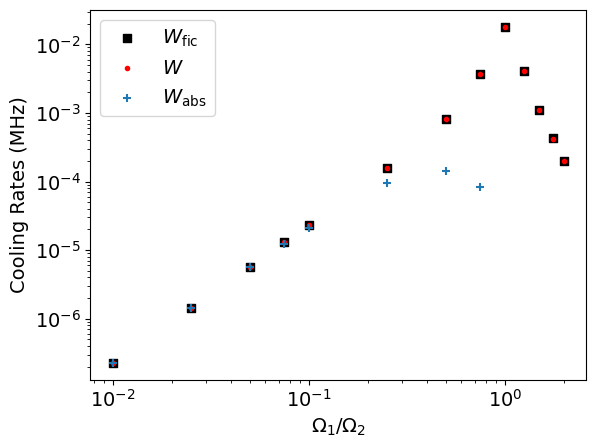

In [20]:
plt.figure()

plt.scatter(ratios,wfic.real,marker='s',color='black',label=r'$W_{\text{fic}}$')
plt.scatter(ratios,w.real,marker='.',label=r'$W$',color='red')
plt.scatter(ratios,2*wabs,marker='+',label=r'$W_{\text{abs}}$')
#ax4.scatter([1,2,3,4,5,6],wexp,marker='+',label='$W_{exp}$',color=['black','royalblue','lightblue'])
plt.yscale('log')
plt.xscale('log')

plt.ylabel('Cooling Rates (MHz)')
plt.xlabel('$\Omega_1/\Omega_2$')
plt.legend()
plt.show()

## Cooling

In [ ]:
t = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_34_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_34_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t1 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_29.75_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n1 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_29.75_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t2 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_25.5_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n2 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_25.5_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t3 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_21.25_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n3 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegap_21.25_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t4 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_17_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n4 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_17_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t5 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_12.75_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n5 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_12.75_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t6 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_8.5_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n6 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_8.5_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t7 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_4.25_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n7 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_4.25_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t8 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_1.7000000000000002_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n8 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_1.7000000000000002_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t9 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_1.275_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n9 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_1.275_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [ ]:
t10 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_0.8500000000000001_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 0]
n10 = np.loadtxt(""+str(path_name)+"cooling_EIT_Omegag_0.8500000000000001_Omegar_17_Delta_70_Gamma1_10.0_Gamma2_10.0_eta_0.01.txt")[:, 1]

In [33]:
t10[-1]

750000.0

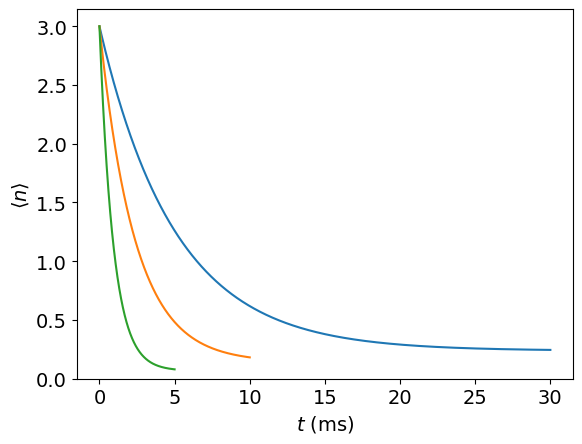

In [34]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t*1e-3,n)
plt.plot(t1*1e-3,n1)
plt.plot(t2*1e-3,n2)
#plt.plot(t3*1e-3,n3)
#plt.plot(t4*1e-3,n4)
#plt.plot(t5*1e-3,n5)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (ms)')
plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)


#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [35]:
def func(t,a,b,c):
    return a*np.exp(-b*t) + c*(1-np.exp(-b*t))

In [36]:
p0 = (3, .001,.001)
popt, pcov = curve_fit(func,t,n,p0)
popt

array([2.99637133e+00, 1.98492759e-04, 2.38612870e-01])

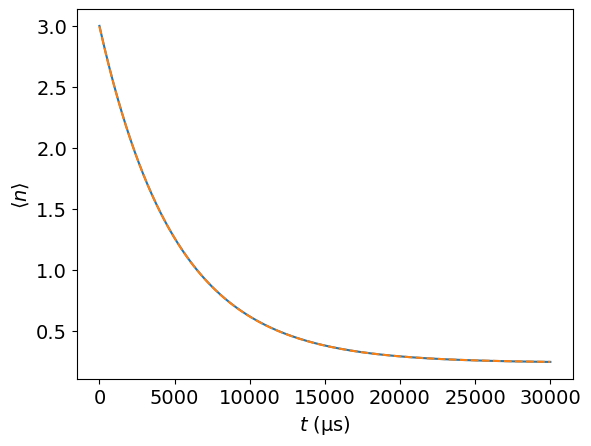

In [37]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t,n)
plt.plot(t,func(t,*popt),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [38]:
p0 = (3, .001,.001)
popt1, pcov = curve_fit(func,t1,n1,p0)
popt1

array([2.99648508e+00, 4.25750706e-04, 1.42266508e-01])

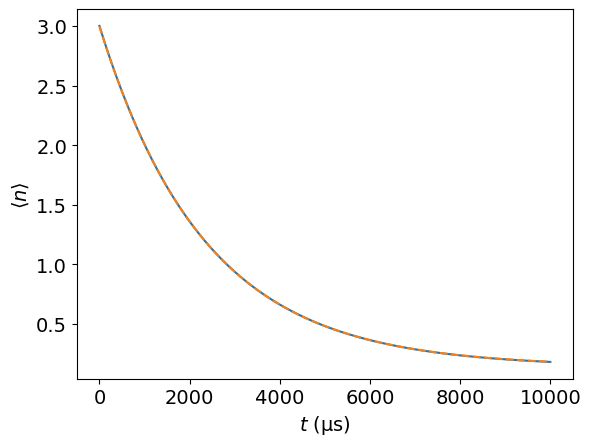

In [39]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t1,n1)
plt.plot(t1,func(t1,*popt1),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [40]:
p0 = (3, .001,.001)
popt2, pcov = curve_fit(func,t2,n2,p0)
popt2

array([3.00081471e+00, 1.08537562e-03, 6.66856662e-02])

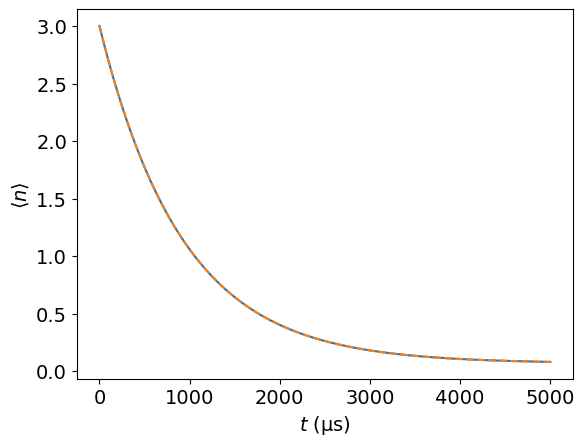

In [41]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t2,n2)
plt.plot(t2,func(t2,*popt2),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [42]:
p0 = (3, .001,.001)
popt3, pcov = curve_fit(func,t3,n3,p0)
popt3

array([3.00786086, 0.00406961, 0.01726423])

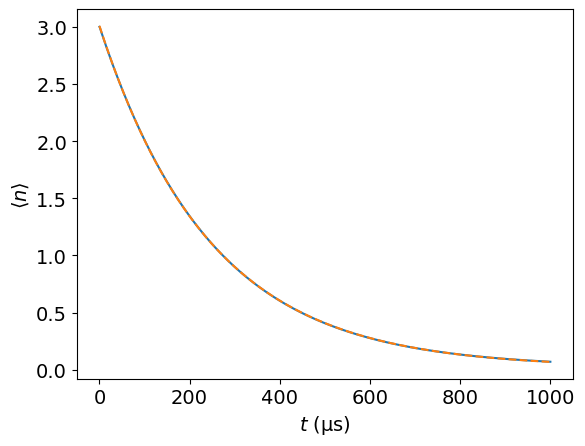

In [43]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t3,n3)
plt.plot(t3,func(t3,*popt3),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [44]:
p0 = (3, .001,.001)
popt4, pcov = curve_fit(func,t4,n4,p0)
popt4

array([3.08542317, 0.01705878, 0.00369935])

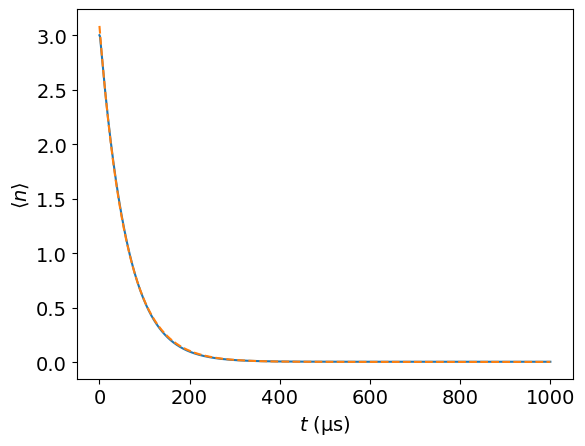

In [45]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t4,n4)
plt.plot(t4,func(t4,*popt4),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [46]:
p0 = (3, .001,.001)
popt5, pcov = curve_fit(func,t5,n5,p0)
popt5

array([3.01006544, 0.00365789, 0.01754474])

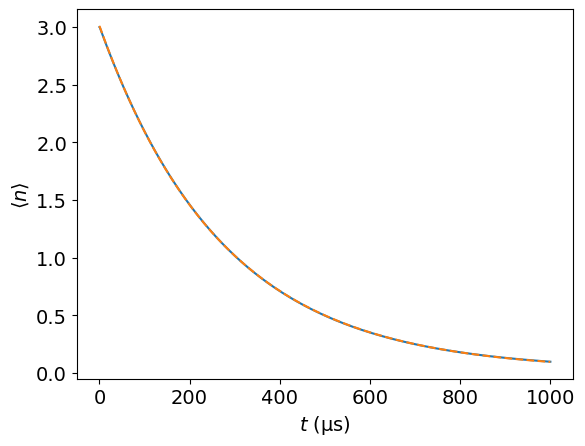

In [47]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t5,n5)
plt.plot(t5,func(t5,*popt5),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [48]:
p0 = (3, .001,.001)
popt6, pcov = curve_fit(func,t6,n6,p0)
popt6

array([3.00302455e+00, 8.24180969e-04, 6.77601226e-02])

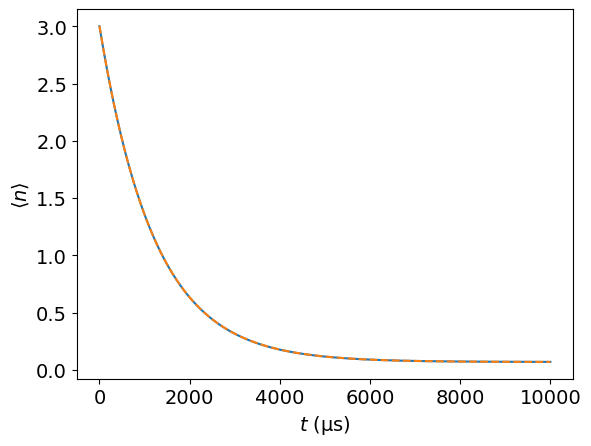

In [49]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t6,n6)
plt.plot(t6,func(t6,*popt6),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [50]:
p0 = (3, .001,.001)
popt7, pcov = curve_fit(func,t7,n7,p0)
popt7

array([3.00059282e+00, 1.54554715e-04, 1.20738864e-01])

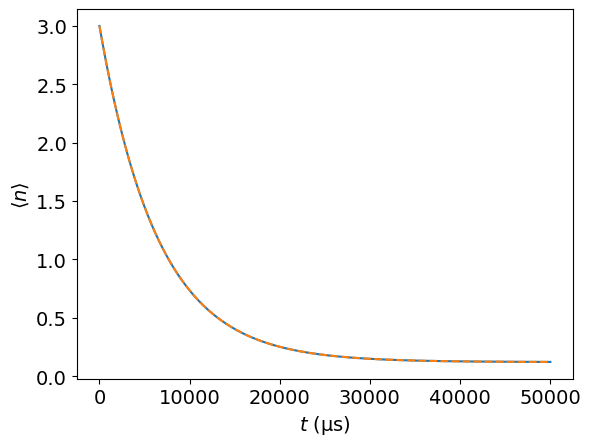

In [51]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t7,n7)
plt.plot(t7,func(t7,*popt7),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [52]:
p0 = (3, .001,.001)
popt8, pcov = curve_fit(func,t8,n8,p0)
popt8

array([2.99994014e+00, 2.31030081e-05, 1.40849170e-01])

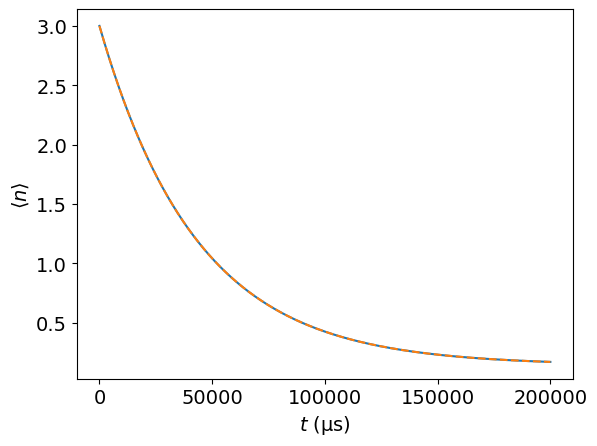

In [53]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t8,n8)
plt.plot(t8,func(t8,*popt8),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [54]:
p0 = (3, .001,.001)
popt9, pcov = curve_fit(func,t9,n9,p0)
popt9

array([2.99989514e+00, 1.29250062e-05, 1.42668024e-01])

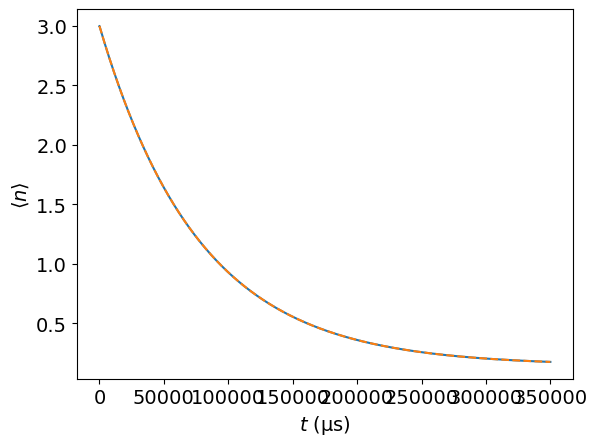

In [55]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t9,n9)
plt.plot(t9,func(t9,*popt9),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [56]:
p0 = (3, .001,.001)
popt10, pcov = curve_fit(func,t10,n10,p0)
popt10

C:\Users\kfouka\AppData\Local\Temp\ipykernel_9668\655354506.py:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*t) + c*(1-np.exp(-b*t))
C:\Users\kfouka\AppData\Local\Temp\ipykernel_9668\655354506.py:2: RuntimeWarning: invalid value encountered in add
  return a*np.exp(-b*t) + c*(1-np.exp(-b*t))


array([2.99985379e+00, 5.72221074e-06, 1.43965440e-01])

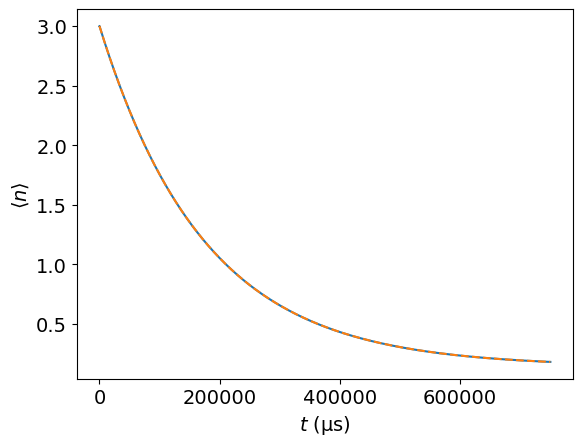

In [57]:
plt.figure()
#plt.title("I=1")

#plt.plot(np.linspace(-10*GammaJgJe,20*GammaJgJe,200),pope1)
plt.plot(t10,n10)
plt.plot(t10,func(t10,*popt10),'--')
#plt.plot(t2,n2)
#plt.plot(t3,n3)


plt.ylabel('$\\langle n \\rangle$')
plt.xlabel('$t$ (μs)')
#plt.ylim(0)
#plt.axvline(10.787075035802768, linestyle='--')
#plt.axvline(65, linestyle='--' )
#plt.xlim(0,2)
#plt.yscale("log")

#plt.legend()
#plt.savefig("I1_cooling_diff_in_state.png",bbox_inches = "tight")
plt.show()

In [58]:
Ratios = [0.05,0.075,0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2]

In [59]:
wexp = [popt10[1],popt9[1],popt8[1],popt7[1],popt6[1],popt5[1],popt4[1],popt3[1],popt2[1],popt1[1],popt[1]]

In [60]:
plt.rcParams.update({'font.size': 8})

In [61]:
wfic

array([2.28667489e-07+1.03946581e-23j, 1.43010092e-06-1.66314530e-22j,
       5.73371698e-06+0.00000000e+00j, 1.29511196e-05-1.99577436e-21j,
       2.31505388e-05+2.66103248e-21j, 1.54923790e-04-2.12882599e-20j,
       8.28086887e-04-8.51530395e-20j, 3.72420052e-03-2.12882599e-19j,
       1.76780156e-02+0.00000000e+00j, 4.12335905e-03+0.00000000e+00j,
       1.08889890e-03+0.00000000e+00j, 4.26939767e-04+1.70306079e-19j,
       1.99104326e-04-4.25765198e-20j])

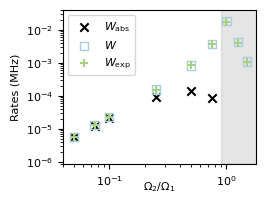

In [62]:
plt.figure(figsize=(2.5,2))
plt.fill_between(np.linspace(0.9,2.25,1000),y1=9e-7,y2=4e-2, color='grey', alpha=0.2)
#plt.scatter(ratios[:-2],wfic.real[:-2],marker='d',label=r'$W_{\text{fic}}$',color='white',edgecolor = '#1f78b4',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(ratios[:-2],2*wabs[:-2],marker='x',label=r'$W_{\text{abs}}$',color='black',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(ratios[:-2],w.real[:-2],marker='s',label=r'$W$',facecolor='none',edgecolor = '#a6cee3',s=plt.rcParams['lines.markersize'] ** 2)
plt.scatter(Ratios[:-2],wexp[:-2],marker='+',label=r'$W_{\text{exp}}$',color='#a7cf82',s=plt.rcParams['lines.markersize'] ** 2)


#ax4.scatter([1,2,3,4,5,6],wexp,marker='+',label='$W_{exp}$',color=['black','royalblue','lightblue'])
plt.yscale('log')
plt.xscale('log')
plt.xlim(4e-2,1.8)
plt.ylim(9e-7,4e-2)
plt.ylabel('Rates (MHz)')
plt.xlabel('$\Omega_2/\Omega_1$',labelpad=-5)

plt.legend(prop={'size': 8})
plt.savefig("eit_Omega1_2.pdf",bbox_inches = "tight")
plt.show()
